In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None
sys.path.insert(0,str(repo_path / 'detr')) if str(repo_path / 'detr') not in sys.path else None

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.structures import pairwise_iou, boxes
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, launch
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_train_loader
from detectron2.solver.build import maybe_add_gradient_clipping

from typing import Any, Dict, List, Set
import itertools
import random

import torch
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [13]:
thing_classes = ["mass"]
len(thing_classes)

1

Important functions

In [26]:
class Trainer(DefaultTrainer):
    """
    Extension of the Trainer class adapted to DETR.
    """

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        """
        Create evaluator(s) for a given dataset.
        This uses the special metadata "evaluator_type" associated with each builtin dataset.
        For your own dataset, you can simply create an evaluator manually in your
        script and do not have to worry about the hacky if-else logic here.
        """
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=None)

    @classmethod
    def build_optimizer(cls, cfg, model):
        params: List[Dict[str, Any]] = []
        memo: Set[torch.nn.parameter.Parameter] = set()
        for key, value in model.named_parameters(recurse=True):
            if not value.requires_grad:
                continue
            # Avoid duplicating parameters
            if value in memo:
                continue
            memo.add(value)
            lr = cfg.SOLVER.BASE_LR
            weight_decay = cfg.SOLVER.WEIGHT_DECAY
            if "backbone" in key:
                lr = lr * cfg.SOLVER.BACKBONE_MULTIPLIER
            params += [{"params": [value], "lr": lr, "weight_decay": weight_decay}]

        def maybe_add_full_model_gradient_clipping(optim):  # optim: the optimizer class
            # detectron2 doesn't have full model gradient clipping now
            clip_norm_val = cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE
            enable = (
                cfg.SOLVER.CLIP_GRADIENTS.ENABLED
                and cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE == "full_model"
                and clip_norm_val > 0.0
            )

            class FullModelGradientClippingOptimizer(optim):
                def step(self, closure=None):
                    all_params = itertools.chain(*[x["params"] for x in self.param_groups])
                    torch.nn.utils.clip_grad_norm_(all_params, clip_norm_val)
                    super().step(closure=closure)

            return FullModelGradientClippingOptimizer if enable else optim

        optimizer_type = cfg.SOLVER.OPTIMIZER
        if optimizer_type == "SGD":
            optimizer = maybe_add_full_model_gradient_clipping(torch.optim.SGD)(
                params, cfg.SOLVER.BASE_LR, momentum=cfg.SOLVER.MOMENTUM
            )
        elif optimizer_type == "ADAMW":
            optimizer = maybe_add_full_model_gradient_clipping(torch.optim.AdamW)(
                params, cfg.SOLVER.BASE_LR
            )
        else:
            raise NotImplementedError(f"no optimizer type {optimizer_type}")
        if not cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE == "full_model":
            optimizer = maybe_add_gradient_clipping(cfg, optimizer)
        return optimizer
    
def get_CEM_dicts(dataframe, im_dir):
        """define a ddataset dictionary for detectron2

        Args:
            dataframe (pd.DataFrame): dataframe with the following columns:
            image_name, bbox, image_id, patient_id

        Returns:
            list: list of dictionaries with the following keys:
            file_name, image_id, height, width, annotations
        """
        dataset_dicts = []
        df = dataframe.copy()

        df['image_id'] = df['image_name'].astype('category').cat.codes


        for _, row in df.iterrows():
            
            record = {}
            
            filename = im_dir / (row["image_name"] + ".jpg")
            height, width = cv.imread(str(filename)).shape[:2]
            
            record["file_name"] = str(filename)
            record["image_id"] = row["image_id"]
            record["height"] = height
            record["width"] = width
            

            bbox_roi = eval(row["bbox"])   
            px = [bbox_roi[0], bbox_roi[0]+bbox_roi[2], bbox_roi[0]+bbox_roi[2], bbox_roi[0]]
            py = [bbox_roi[1], bbox_roi[1], bbox_roi[1]+bbox_roi[3], bbox_roi[1]+bbox_roi[3]]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            objs = []
            obj =  {
                    "bbox": [bbox_roi[0] , bbox_roi[1], bbox_roi[0]+bbox_roi[2], bbox_roi[1]+bbox_roi[3]],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": [poly],
                    "category_id": 0,
                }
            objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)

        return dataset_dicts

Setting things up

In [27]:
# parameters
iter_num = 30000
p_CEM = "30k"

# tests:. 101 vs R2
m_layer = 'R_101'
g_rgb = "gray" # if we train with rgb or grayscale
csv_meta_path = repo_path / 'data/CDD-CESM/metadata/bboxes/split_1/train_set.csv'
im_dir = repo_path / 'data/CDD-CESM/images/substracted'

In [28]:
DatasetCatalog.clear()
# register our dataset
registraiton_name = "CEM_train"
DatasetCatalog.register(registraiton_name, lambda: get_CEM_dicts(dataframe=pd.read_csv(csv_meta_path), im_dir=im_dir))
MetadataCatalog.get(registraiton_name).set(thing_classes=["mass"])
CEM_metadata = MetadataCatalog.get(registraiton_name)

### Visualize some random images form the train dataset

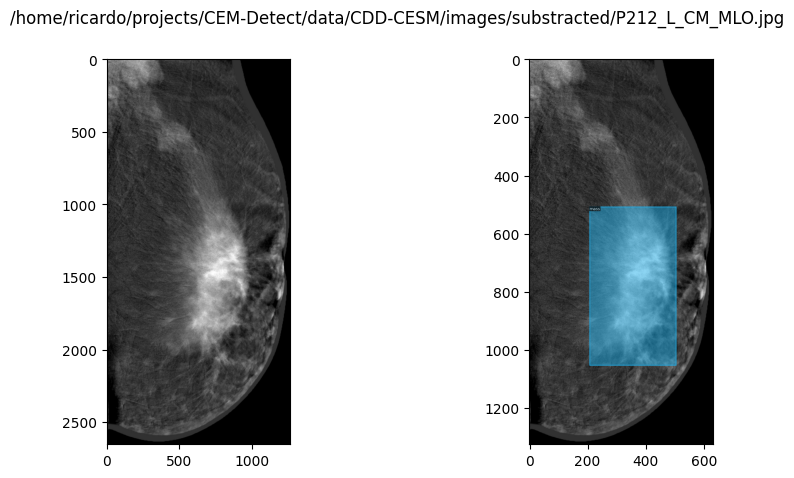

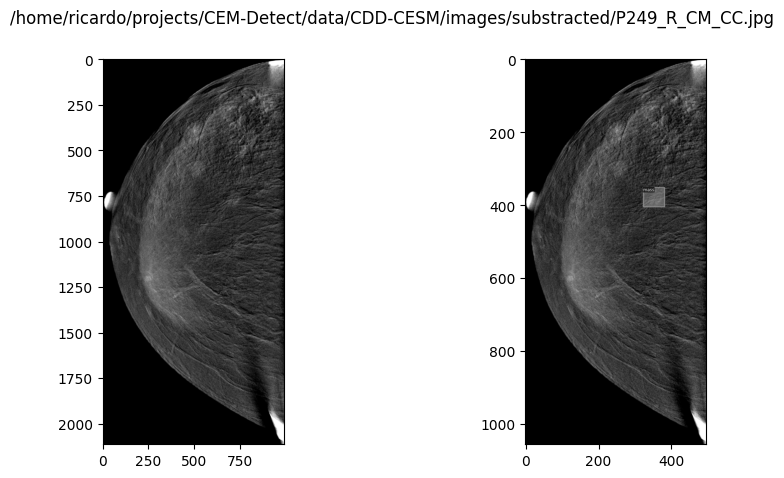

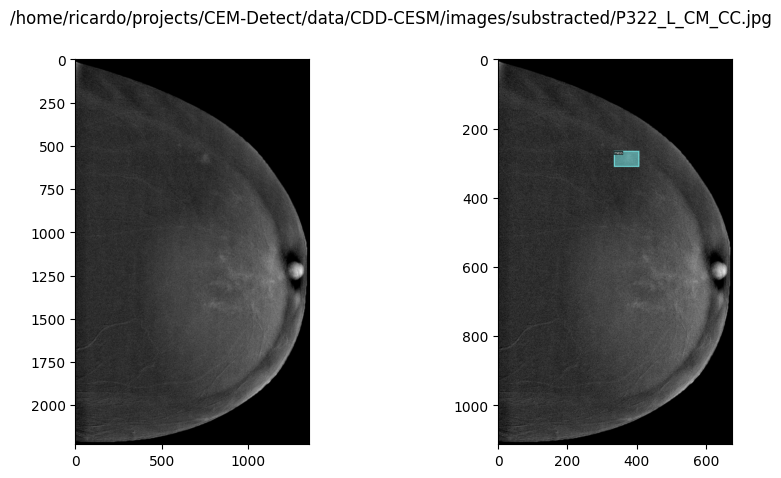

In [16]:
dataset_dicts = get_CEM_dicts(dataframe=pd.read_csv(csv_meta_path), im_dir=im_dir)
for d in random.sample(dataset_dicts, 3):
    img = cv.imread(d["file_name"])
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=CEM_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    axs[1].imshow(out.get_image()[:, :, ::-1])
    fig.suptitle(d["file_name"])
    plt.show()

### Training

In [29]:
config_file = repo_path / 'detection/training/data/config_files/fine_tuning_CEM.yaml'
model_file = repo_path / 'data/models/model_final_R_101_omidb_30k_dbt9k_f12_gray.pth'

In [30]:
cfg = get_cfg()

cfg.merge_from_file(str(config_file))
cfg.MODEL.WEIGHTS = str(model_file)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = iter_num #10000    # 300 iterations is enough for a toy dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (mass).

cfg.DATASETS.TRAIN = (registraiton_name,)
cfg.DATASETS.TEST = ()

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = Trainer(cfg)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()



[02/20 18:04:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/home/ricardo/miniconda3/envs/detectron-new/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/20 18:04:45 d2.utils.events]:  eta: 1:40:14  iter: 19  total_loss: 0.3265  loss_cls: 0.1683  loss_box_reg: 0.06296  loss_rpn_cls: 0.09246  loss_rpn_loc: 0.005927    time: 0.2213  last_time: 0.2029  data_time: 0.0169  last_data_time: 0.0048   lr: 4.9953e-06  max_mem: 3288M
[02/20 18:04:49 d2.utils.events]:  eta: 1:36:27  iter: 39  total_loss: 0.3328  loss_cls: 0.1927  loss_box_reg: 0.0736  loss_rpn_cls: 0.06332  loss_rpn_loc: 0.006838    time: 0.2078  last_time: 0.1819  data_time: 0.0041  last_data_time: 0.0036   lr: 9.9902e-06  max_mem: 3288M
[02/20 18:04:54 d2.utils.events]:  eta: 1:36:59  iter: 59  total_loss: 0.2819  loss_cls: 0.1458  loss_box_reg: 0.0664  loss_rpn_cls: 0.05197  loss_rpn_loc: 0.004407    time: 0.2094  last_time: 0.1823  data_time: 0.0044  last_data_time: 0.0040   lr: 1.4985e-05  max_mem: 3288M
[02/20 18:04:58 d2.utils.events]:  eta: 1:36:29  iter: 79  total_loss: 0.3218  loss_cls: 0.1856  loss_box_reg: 0.08672  loss_rpn_cls: 0.03032  loss_rpn_loc: 0.005265    ti